Block Matching

In [117]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
ref_frame = cv2.imread('reference_frame.jpg', cv2.IMREAD_GRAYSCALE)

In [122]:
current_frame = cv2.imread('current_frame.jpg', cv2.IMREAD_GRAYSCALE)

In [123]:
def exhaustive_block_matching(current_frame, ref_frame, block_size):
    # Calculate dimensions
    frame_height, frame_width = current_frame.shape[:2]
    ref_height, ref_width = ref_frame.shape[:2]

    # Number of blocks in each dimension
    num_blocks_y = frame_height // block_size
    num_blocks_x = frame_width // block_size

    # List to store motion vectors
    motion_vectors = []

    # Iterate over blocks in the current frame
    for by in range(num_blocks_y):
        for bx in range(num_blocks_x):
            # Define block boundaries
            y_start = by * block_size
            y_end = min(y_start + block_size, frame_height)
            x_start = bx * block_size
            x_end = min(x_start + block_size, frame_width)

            # Define current block
            current_block = current_frame[y_start:y_end, x_start:x_end]

            # Initialize variables to track best match
            min_ssd = float('inf')
            best_match = None

            # Iterate over search area in the reference frame
            for dy in range(max(-y_start, -ref_height + 1), min(frame_height - y_end, ref_height)):
                for dx in range(max(-x_start, -ref_width + 1), min(frame_width - x_end, ref_width)):
                    # Define search window boundaries
                    ref_y_start = max(0, y_start + dy)
                    ref_y_end = min(ref_height, y_end + dy)
                    ref_x_start = max(0, x_start + dx)
                    ref_x_end = min(ref_width, x_end + dx)

                    # Extract block from reference frame
                    ref_block = ref_frame[ref_y_start:ref_y_end, ref_x_start:ref_x_end]

                    # Pad blocks if necessary
                    padded_current_block = np.zeros_like(ref_block)
                    padded_ref_block = np.zeros_like(ref_block)
                    padded_current_block[:current_block.shape[0], :current_block.shape[1]] = current_block
                    padded_ref_block[:ref_block.shape[0], :ref_block.shape[1]] = ref_block

                    # Compute SSD (Sum of Squared Differences)
                    ssd = np.sum((padded_current_block - padded_ref_block) ** 2)

                    # Update best match if SSD is smaller
                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_match = (dy, dx)

            # Compute motion vector
            motion_vectors.append((y_start, x_start, best_match[0], best_match[1]))

    return motion_vectors

In [124]:
motion_vectors = exhaustive_block_matching(current_frame, ref_frame, block_size=16)

In [125]:
def plot_motion_vectors(current_frame_path, motion_vectors, block_size):
    # Create figure and axis
    fig, ax = plt.subplots()

    # Plot the current frame
    ax.imshow(current_frame)

    # Plot motion vectors
    for mv in motion_vectors:
        y, x, dy, dx = mv
        # Draw arrow representing motion vector
        ax.arrow(x + block_size // 2, y + block_size // 2, dx, dy, head_width=5, head_length=5, fc='red', ec='red')

    # Set axis limits and aspect ratio
    ax.set_xlim(0, current_frame.shape[1])
    ax.set_ylim(current_frame.shape[0], 0)  # Inverted y-axis to match image coordinates
    ax.set_aspect('equal')

    # Show plot
    plt.show()

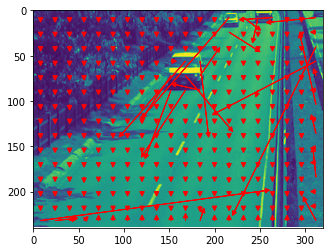

In [126]:
plot_motion_vectors(current_frame, motion_vectors, block_size=16)

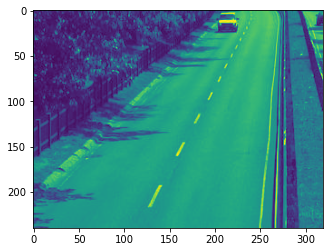

In [8]:
plt.imshow(ref_frame)

In [127]:
def three_step_search(current_frame, reference_frame, initial_step_size=4, search_range=30, block_size=(3, 3)):
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    reference_frame_gray = cv2.cvtColor(reference_frame, cv2.COLOR_BGR2GRAY)

    height, width = current_frame_gray.shape
    block_height, block_width = block_size
    half_step = initial_step_size // 2

    min_sad = float('inf')
    motion_vector = (0, 0)

    for i in range(-search_range, search_range + 1, initial_step_size):
        for j in range(-search_range, search_range + 1, initial_step_size):
            y_start = max(0, -i)
            y_end = min(height, height - i)
            x_start = max(0, -j)
            x_end = min(width, width - j)

            shifted_block = reference_frame_gray[y_start:y_end, x_start:x_end]
            current_block = current_frame_gray[y_start:y_end, x_start:x_end]

            sad = np.sum(np.abs(current_block - shifted_block))

            if sad < min_sad:
                min_sad = sad
                motion_vector = (j, i)

    return motion_vector

# Load current frame and reference frame images
current_frame = cv2.imread('current_frame.jpg')
reference_frame = cv2.imread('reference_frame.jpg')

# Perform block matching using Three-Step Search
motion_vector = three_step_search(current_frame, reference_frame)

print("Motion Vector:", motion_vector)


Motion Vector: (30, -30)


In [129]:
# Plot motion vector on current frame
arrow_length = 20
arrow_thickness = 2
color = (0, 255, 0)  # Green color for the arrow

# Get the center of the current frame
center_x = current_frame.shape[1] // 2
center_y = current_frame.shape[0] // 2

# Calculate the end point of the arrow based on the motion vector
end_x = center_x + motion_vector[0]
end_y = center_y + motion_vector[1]

# Draw the arrow on the current frame
cv2.arrowedLine(current_frame, (center_x, center_y), (end_x, end_y), color, arrow_thickness)

# Display the current frame with the motion vector
cv2.imshow('Current Frame with Motion Vector', current_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [130]:
def orthogonal_search(current_frame, reference_frame, block_size=(8, 8), search_range=16):
    current_frame_gray = cv2.cvtColor(current_frame, cv2.COLOR_BGR2GRAY)
    reference_frame_gray = cv2.cvtColor(reference_frame, cv2.COLOR_BGR2GRAY)

    height, width = current_frame_gray.shape
    block_height, block_width = block_size

    min_sad = float('inf')
    motion_vector = (0, 0)

    for i in range(-search_range, search_range + 1):
        for j in range(-search_range, search_range + 1):
            x_start = max(0, -j)
            x_end = min(width, width - j)
            y_start = max(0, -i)
            y_end = min(height, height - i)

            shifted_block = reference_frame_gray[y_start:y_end, x_start:x_end]
            current_block = current_frame_gray[max(0, i):min(height, height + i), max(0, j):min(width, width + j)]

            sad = np.sum(np.abs(current_block - shifted_block))

            if sad < min_sad:
                min_sad = sad
                motion_vector = (j, i)

    return motion_vector

In [131]:
motion_vector = orthogonal_search(current_frame, reference_frame)
print("Motion Vector:", motion_vector)

Motion Vector: (8, -16)


In [132]:
# Plot motion vector on current frame
arrow_length = 20
arrow_thickness = 2
color = (0, 255, 0)  # Green color for the arrow

# Get the center of the current frame
center_x = current_frame.shape[1] // 2
center_y = current_frame.shape[0] // 2

# Calculate the end point of the arrow based on the motion vector
end_x = center_x + motion_vector[0]
end_y = center_y + motion_vector[1]

# Draw the arrow on the current frame
cv2.arrowedLine(current_frame, (center_x, center_y), (end_x, end_y), color, arrow_thickness)

# Display the current frame with the motion vector
cv2.imshow('Current Frame with Motion Vector', current_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()
